In [1]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import v2
from tqdm.auto import tqdm

In [2]:
writer = SummaryWriter(f'runs/mnist/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 5
latent_dim = 2
hidden_dim = 512

In [3]:
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1) - 0.5),
])

In [4]:
# Download and load the training data
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform=transform,
)
len(train_data)

60000

In [5]:
# Download and load the test data
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform,
)
len(test_data)

10000

In [6]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [7]:
@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.
    
    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor
    
    loss: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor

In [8]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(VAE, self).__init__()
        self.num_classes = num_classes
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, 2 * latent_dim), # 2 for mean and variance.
        )
        self.softplus = nn.Softplus()
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )
        
    def encode(self, x, y, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.
        
        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.
        
        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        y_onehot = F.one_hot(y, num_classes=self.num_classes).float()
        x = torch.cat([x, y_onehot], dim=-1)
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        
        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        
    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.
        
        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.

        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()
    
    def decode(self, z, y):
        """
        Decodes the data from the latent space to the original input space.
        
        Args:
            z (torch.Tensor): Data in the latent space.
        
        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        y_onehot = F.one_hot(y, num_classes=self.num_classes).float()

        z = torch.cat([z, y_onehot], dim=-1)


        return self.decoder(z)
    
    def forward(self, x, y, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.
        
        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.
        
        Returns:
            VAEOutput: VAE output dataclass.
            """
        dist = self.encode(x, y)
        z = self.reparameterize(dist)
        recon_x = self.decode(z, y)
        
        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon=None,
                loss_kl=None,
            )
        
        # compute loss terms 
        loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()
                
        loss = loss_recon + loss_kl
        
        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )

In [9]:
num_classes = 10  # MNIST has 10 classes (digits 0-9)
model = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim, num_classes=num_classes).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 1,155,732


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SiLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): SiLU()
    (8): Linear(in_features=64, out_features=4, bias=True)
  )
  (softplus): Softplus(beta=1.0, threshold=20.0)
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): SiLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): SiLU()
    (8): Linear(in_features=512, out_features=784, bias=True)
    (9): Sigmoid()
  )
)

In [10]:
# create an optimizer object
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [11]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.
    
    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        output = model(data, target)  # Forward pass
        loss = output.loss
        
        loss.backward()
        
        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', output.loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', output.loss_kl.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  # Update the model parameters
        
    return prev_updates + len(dataloader)

In [12]:
def test(model, dataloader, cur_step, writer=None):
    """
    Tests the model on the given data.
    
    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            target = target.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data
            
            output = model(data, target, compute_loss=True)  # Forward pass
            
            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()
            
    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', output.loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', output.loss_kl.item(), global_step=cur_step)
        
        # Log reconstructions
        writer.add_images('Test/Reconstructions', output.x_recon.view(-1, 1, 28, 28), global_step=cur_step)
        writer.add_images('Test/Originals', data.view(-1, 1, 28, 28), global_step=cur_step)
        
        # Log random samples from the latent space
        z = torch.randn(16, latent_dim).to(device)
        y = torch.randint(0, model.num_classes, (16,), device=device)
        samples = model.decode(z, y)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [13]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/5


  0%|          | 0/469 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 544.1499 (Recon: 543.9432, KL: 0.2067) Grad: 13.0216
Step 100 (N samples: 12,800), Loss: 194.3383 (Recon: 192.5571, KL: 1.7812) Grad: 16.6833
Step 200 (N samples: 25,600), Loss: 173.7855 (Recon: 171.8235, KL: 1.9620) Grad: 22.2499
Step 300 (N samples: 38,400), Loss: 167.2337 (Recon: 165.1882, KL: 2.0455) Grad: 16.9624
Step 400 (N samples: 51,200), Loss: 169.4713 (Recon: 167.3733, KL: 2.0979) Grad: 29.4717


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 160.0432 (BCE: 157.8344, KLD: 2.2088)
Epoch 2/5


  0%|          | 0/469 [00:00<?, ?it/s]

Step 500 (N samples: 64,000), Loss: 152.5857 (Recon: 149.5734, KL: 3.0123) Grad: 18.3833
Step 600 (N samples: 76,800), Loss: 149.3395 (Recon: 145.5719, KL: 3.7676) Grad: 35.1118
Step 700 (N samples: 89,600), Loss: 148.9716 (Recon: 144.7736, KL: 4.1980) Grad: 45.1791
Step 800 (N samples: 102,400), Loss: 147.4486 (Recon: 143.3065, KL: 4.1422) Grad: 30.7610
Step 900 (N samples: 115,200), Loss: 137.9195 (Recon: 133.5695, KL: 4.3501) Grad: 37.8048


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.4356 (BCE: 135.1503, KLD: 4.2853)
Epoch 3/5


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,000 (N samples: 128,000), Loss: 138.0148 (Recon: 133.5384, KL: 4.4764) Grad: 38.5353
Step 1,100 (N samples: 140,800), Loss: 143.5961 (Recon: 139.1503, KL: 4.4457) Grad: 41.2027
Step 1,200 (N samples: 153,600), Loss: 136.8289 (Recon: 132.1865, KL: 4.6425) Grad: 41.2903
Step 1,300 (N samples: 166,400), Loss: 134.3012 (Recon: 129.5328, KL: 4.7684) Grad: 40.9306
Step 1,400 (N samples: 179,200), Loss: 135.4414 (Recon: 130.9319, KL: 4.5095) Grad: 24.6307


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 135.4590 (BCE: 130.8996, KLD: 4.5593)
Epoch 4/5


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,500 (N samples: 192,000), Loss: 140.9653 (Recon: 136.4184, KL: 4.5469) Grad: 33.0918
Step 1,600 (N samples: 204,800), Loss: 132.2287 (Recon: 127.4267, KL: 4.8020) Grad: 30.1321
Step 1,700 (N samples: 217,600), Loss: 135.4644 (Recon: 130.8743, KL: 4.5901) Grad: 38.7733
Step 1,800 (N samples: 230,400), Loss: 130.8877 (Recon: 126.1445, KL: 4.7432) Grad: 29.3339


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 133.5318 (BCE: 128.7880, KLD: 4.7438)
Epoch 5/5


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,900 (N samples: 243,200), Loss: 146.0470 (Recon: 141.2720, KL: 4.7751) Grad: 32.3255
Step 2,000 (N samples: 256,000), Loss: 130.1803 (Recon: 125.3774, KL: 4.8029) Grad: 42.6980
Step 2,100 (N samples: 268,800), Loss: 131.9841 (Recon: 127.4124, KL: 4.5717) Grad: 44.3082
Step 2,200 (N samples: 281,600), Loss: 132.0091 (Recon: 127.3491, KL: 4.6600) Grad: 25.8210
Step 2,300 (N samples: 294,400), Loss: 131.2846 (Recon: 126.6007, KL: 4.6838) Grad: 36.4446


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 132.8617 (BCE: 128.2019, KLD: 4.6597)


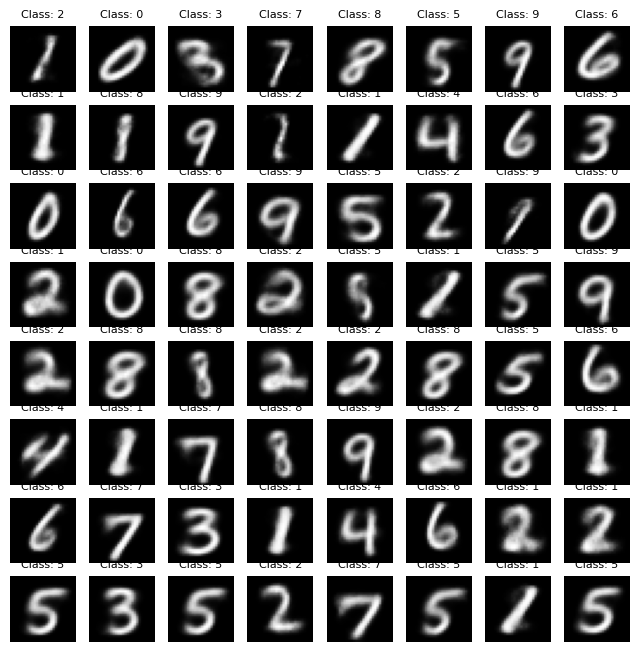

In [14]:
z = torch.randn(64, latent_dim).to(device)
y = torch.randint(0, model.num_classes, (64,), device=device)
samples = model.decode(z, y)
# samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')
        ax[i, j].set_title(f'Class: {y[i*8+j].item()}', fontsize=8)

# plt.show()
plt.savefig('vae_mnist.webp')


In [15]:
# # encode and plot the z values for the train set 
# model.eval()
# z_all = []
# y_all = []
# with torch.no_grad():
#     for data, target in tqdm(train_loader, desc='Encoding'):
#         data = data.to(device)
#         output = model(data, compute_loss=False)
#         z_all.append(output.z_sample.cpu().numpy())
#         y_all.append(target.numpy())

In [16]:
# import numpy as np
# z_all = np.concatenate(z_all, axis=0)
# y_all = np.concatenate(y_all, axis=0)

In [17]:
# plt.figure(figsize=(10, 10))
# plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
# plt.colorbar()
# # plt.show()
# plt.savefig('vae_mnist_2d_scatter.webp')

In [18]:

# # plot as 2d histogram, log scale
# from matplotlib.colors import LogNorm
# plt.figure(figsize=(10, 10))
# plt.hist2d(z_all[:, 0], z_all[:, 1], bins=128, cmap='Blues', norm=LogNorm())
# plt.colorbar()
# # plt.show()
# plt.savefig('vae_mnist_2d_hist.webp')

In [19]:
# # plot 1d histograms
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].hist(z_all[:, 0], bins=100, color='b', alpha=0.7)
# ax[0].set_title('z1')
# ax[1].hist(z_all[:, 1], bins=100, color='b', alpha=0.7)
# ax[1].set_title('z2')
# # plt.show()
# plt.savefig('vae_mnist_1d_hist.webp')

In [20]:
# n = 15
# z1 = torch.linspace(-0, 1, n)
# z2 = torch.zeros_like(z1) + 2
# z = torch.stack([z1, z2], dim=-1).to(device)
# samples = model.decode(z)
# samples = torch.sigmoid(samples)

# # Plot the generated images
# fig, ax = plt.subplots(1, n, figsize=(n, 1))
# for i in range(n):
#     ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
#     ax[i].axis('off')
    
# plt.savefig('vae_mnist_interp.webp')

In [33]:
def generate_samples():
    n = 15
    fig, ax = plt.subplots(10, n, figsize=(n, 10))
    
    for desired_class in range(10):
        y = torch.full((n,), desired_class, dtype=torch.long, device=device)
        z = torch.randn(n, latent_dim).to(device)
        samples = model.decode(z, y)
        samples = torch.sigmoid(samples)
        
        for i in range(n):
            ax[desired_class, i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
            ax[desired_class, i].axis('off')
            ax[desired_class, i].set_title(f'Class: {desired_class}', fontsize=8)
    
    plt.savefig('vae_mnist_all_classes.webp')

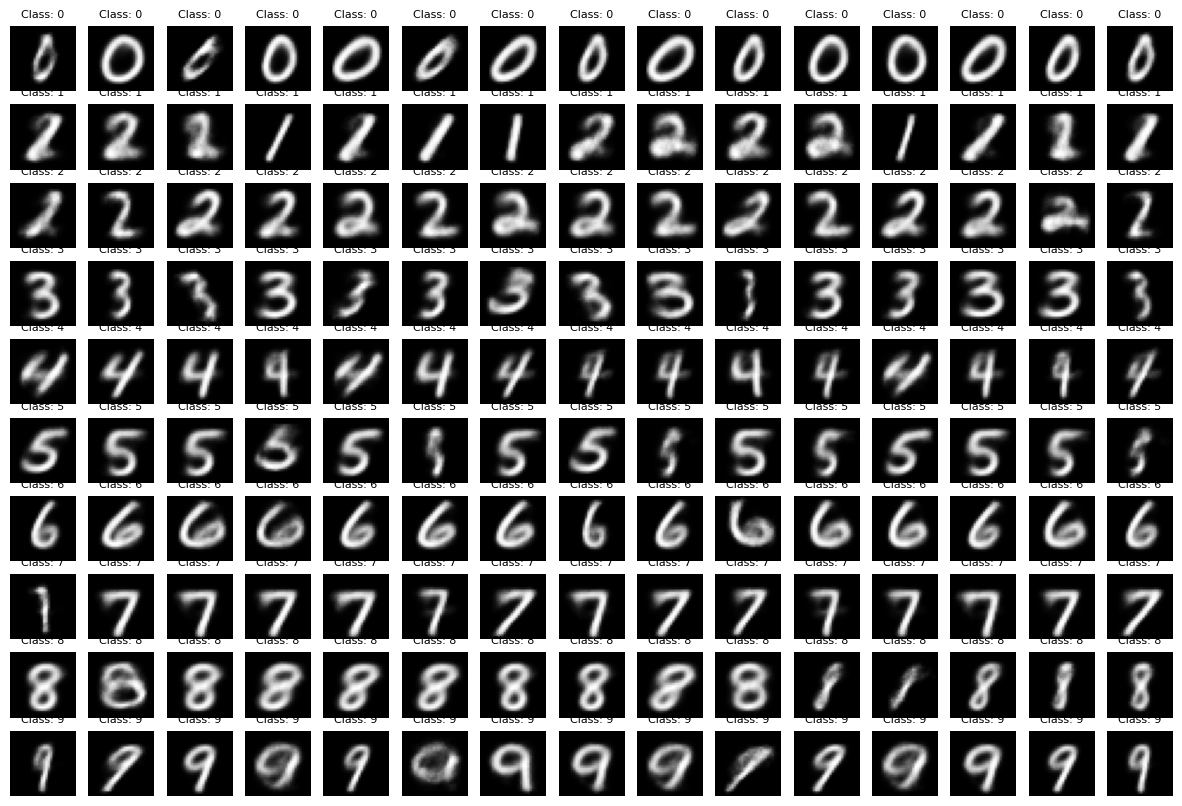

In [34]:
generate_samples()